In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from IPython.core.debugger import set_trace

Using TensorFlow backend.


[<tf.Tensor 'input_from_FrontSS:0' shape=(?, 96, 144, 3) dtype=float32>, <tf.Tensor 'input_from_LeftSS:0' shape=(?, 96, 144, 3) dtype=float32>, <tf.Tensor 'input_from_RightSS:0' shape=(?, 96, 144, 3) dtype=float32>, <tf.Tensor 'input_from_RearSS:0' shape=(?, 96, 144, 3) dtype=float32>, <tf.Tensor 'input_from_TopSS:0' shape=(?, 96, 144, 3) dtype=float32>]
input_from_FrontSS: not-trainable
input_from_LeftSS: not-trainable
input_from_RightSS: not-trainable
input_from_RearSS: not-trainable
encoder_submodel: trainable
flatten_1: trainable
flatten_2: trainable
flatten_3: trainable
flatten_4: trainable
dense_1: trainable
dense_4: trainable
dense_7: trainable
dense_10: trainable
dense_2: trainable
dense_5: trainable
dense_8: trainable
dense_11: trainable
dense_3: trainable
dense_6: trainable
dense_9: trainable
dense_12: trainable
reshape_1: trainable
reshape_2: trainable
reshape_3: trainable
reshape_4: trainable
encoded_from_FrontSS: trainable
encoded_from_LeftSS: trainable
encoded_from_RightS

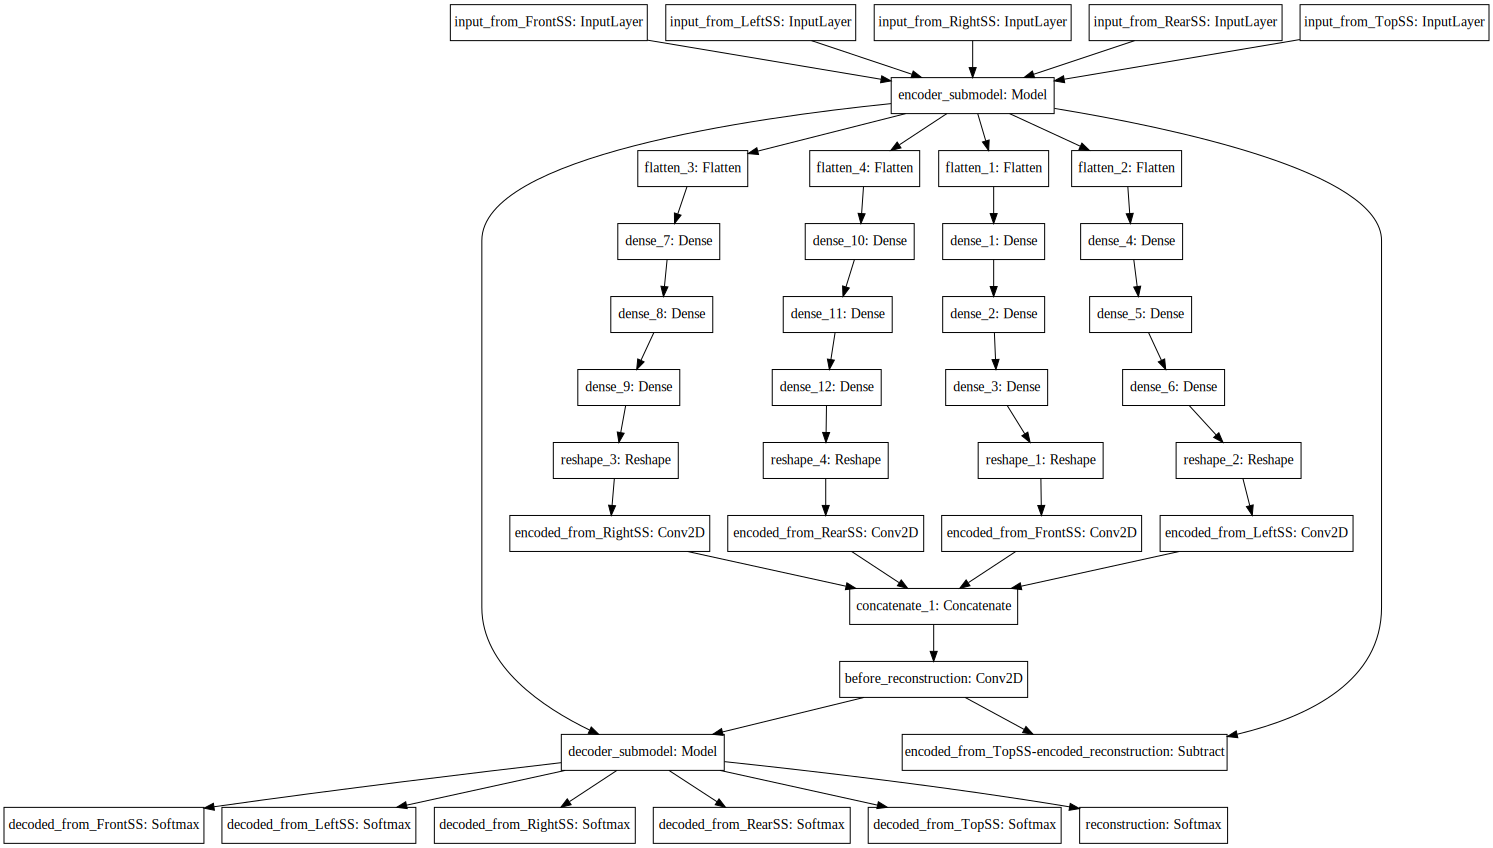

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model


multi_model = load_model('models/multi_model__sweep=23_decimation=2_numclasses=3_valloss=0.044.h5')
print(multi_model.inputs)

for l in multi_model.layers:
    print('{}: {}'.format(l.name, 'trainable' if l.trainable else 'not-trainable'))

SVG(model_to_dot(multi_model).create(prog='dot', format='svg'))

In [ ]:
import pickle
import time
import numpy as np

import keras.backend as K
from keras.models import Model
from keras.layers import Add, Subtract, Average, Flatten, Reshape, Dense, Input, Lambda, Concatenate, Softmax, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D, TimeDistributed

from utils import (
    sequential_batcher, extract_observation_for_batch,
    get_X_and_Y, plot_semantic
)


def get_recur_model(multi_model, seq_len, input_names, train_encoder=True, train_decoder=True):
    input_shape =  K.int_shape(multi_model.input[0])[1:]
    seq_input_shape = (seq_len, *input_shape)
    encoded_dim = K.int_shape(multi_model.get_layer('encoder_submodel').outputs[0])[1:]

    inputs = {
        inp_name: Input(seq_input_shape, name='input_from_'+inp_name)
        for inp_name in input_names
    }

    decoder = multi_model.get_layer('decoder_submodel')
    decoder.trainable = train_decoder
    
    previous_reconstruction_model = Model(
        [multi_model.inputs[inp_idx] for inp_idx, inp_name in enumerate(input_names)],
        multi_model.get_layer('before_reconstruction').output,
    )

    for_reconstruction = []
    for inp_idx, inp_name in enumerate(input_names):
        encoder = Model(
            multi_model.inputs[inp_idx],
            multi_model.get_layer('encoded_from_'+inp_name).output,
        )
        encoder.trainable = train_encoder

        inp = inputs[inp_name]
        x = TimeDistributed(encoder)(inp)
        for_reconstruction.append(x)

    x = Concatenate()(for_reconstruction)
    rec = ConvLSTM2D(
            encoded_dim[-1],
            (3, 3),
            padding='same',
            return_sequences=False,
    )(x)
    rec = Convolution2D(
        encoded_dim[-1],
        (3, 3),
        activation='elu',
        padding='same',
    )(rec)
    rec = decoder(rec)
    
    previous_reconstruction = previous_reconstruction_model([
        Lambda(
            lambda x: x[:, -1, :, :, :],
        )(inputs[inp_name])
        for inp_name in input_names
    ])
    previous_reconstruction = decoder(previous_reconstruction)
    
    added_reconstructions = Add()([rec, previous_reconstruction])
    out = Softmax(axis=3)(added_reconstructions)

    return Model([inputs[inp_name] for inp_name in input_names], out)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:
DECIMATION = 2
SEQUENCE_LEN = 4
SEQ_BATCH_SIZE = 8
CAMERA_IDS = [
    'FrontSS', 'LeftSS', 'RightSS', 'RearSS', 'TopSS'
]
CLASSES_NAMES = [
    ['Roads', 'RoadLines'],
    
    ['None', 'Buildings', 'Fences', 'Other', 'Pedestrians',
     'Poles', 'Walls', 'TrafficSigns',
     'Vegetation', 'Sidewalks'],
    
    ['Vehicles'],
]

# CLASSES_NAMES = [
#     ['Roads', 'RoadLines'],
    
#     ['Sidewalks'],
    
#     ['Buildings'],
    
#     ['Fences', 'Other', 'Pedestrians',
#      'Poles', 'Walls', 'TrafficSigns'],
    
#     ['Vehicles'],
    
#     ['Vegetation'],
        
#     ['None']
# ]


patience = 10


input_names = [camera_id for camera_id in CAMERA_IDS if 'Top' not in camera_id]
train_encoder = False
train_decoder = False


recur_model = get_recur_model(
    multi_model,
    SEQUENCE_LEN,
    input_names,
    train_encoder,
    train_decoder,
)
recur_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-5),  # needs to be low!!!!
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True,
)

storage = get_X_and_Y(['Town01', 'Town02'], [100, 101], DECIMATION, CAMERA_IDS)
X_val = [storage[id_] for id_ in CAMERA_IDS if 'Top' not in id_]
Y_val = [storage[id_] for id_ in CAMERA_IDS if 'Top' in id_][0]
valid_seq_gen = sequential_batcher(
    X_val, Y_val,
    return_sequences=False,
    batch_size=SEQ_BATCH_SIZE,
    sequence_len=SEQUENCE_LEN,
    classes_names=CLASSES_NAMES,
    val_part=1.0,
    validation=True,
)

Reading data took 0.69 [s]


<Figure size 432x288 with 0 Axes>

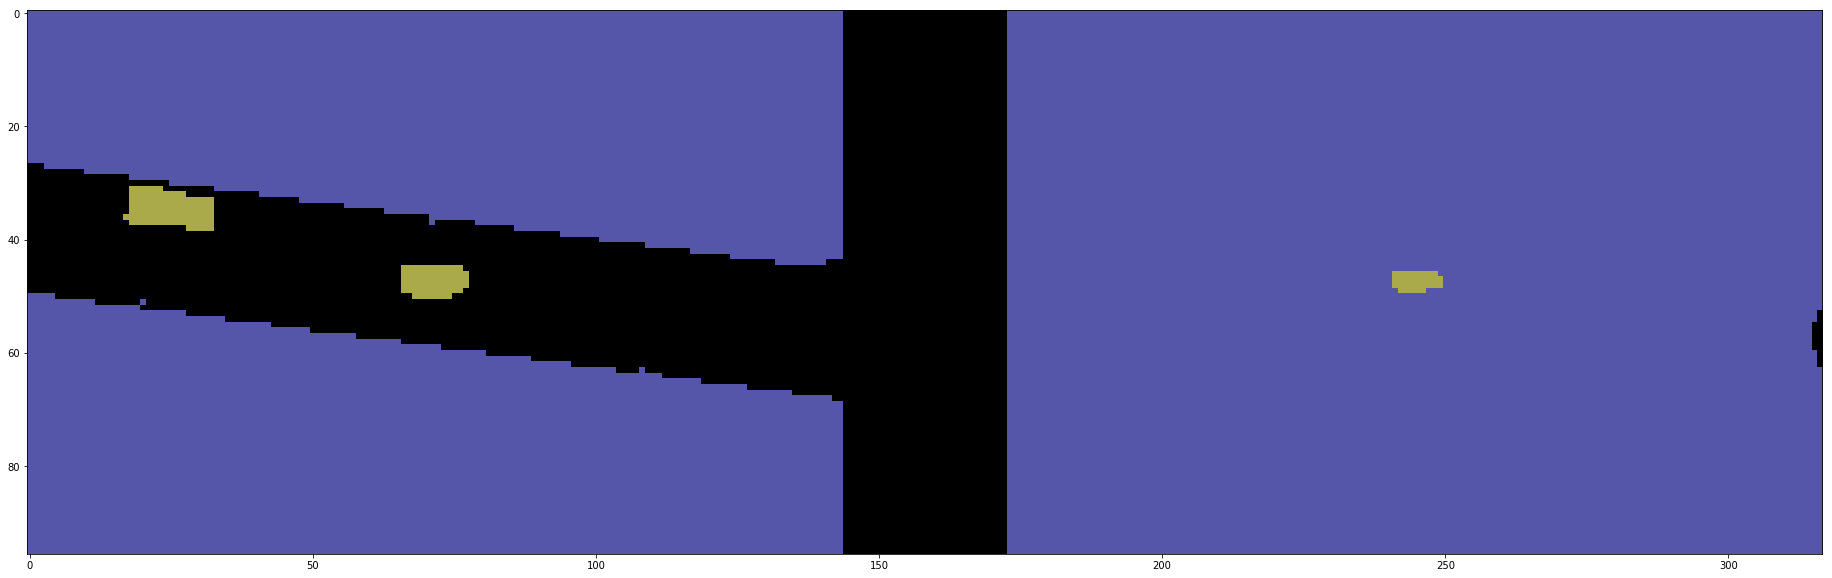

<Figure size 432x288 with 0 Axes>

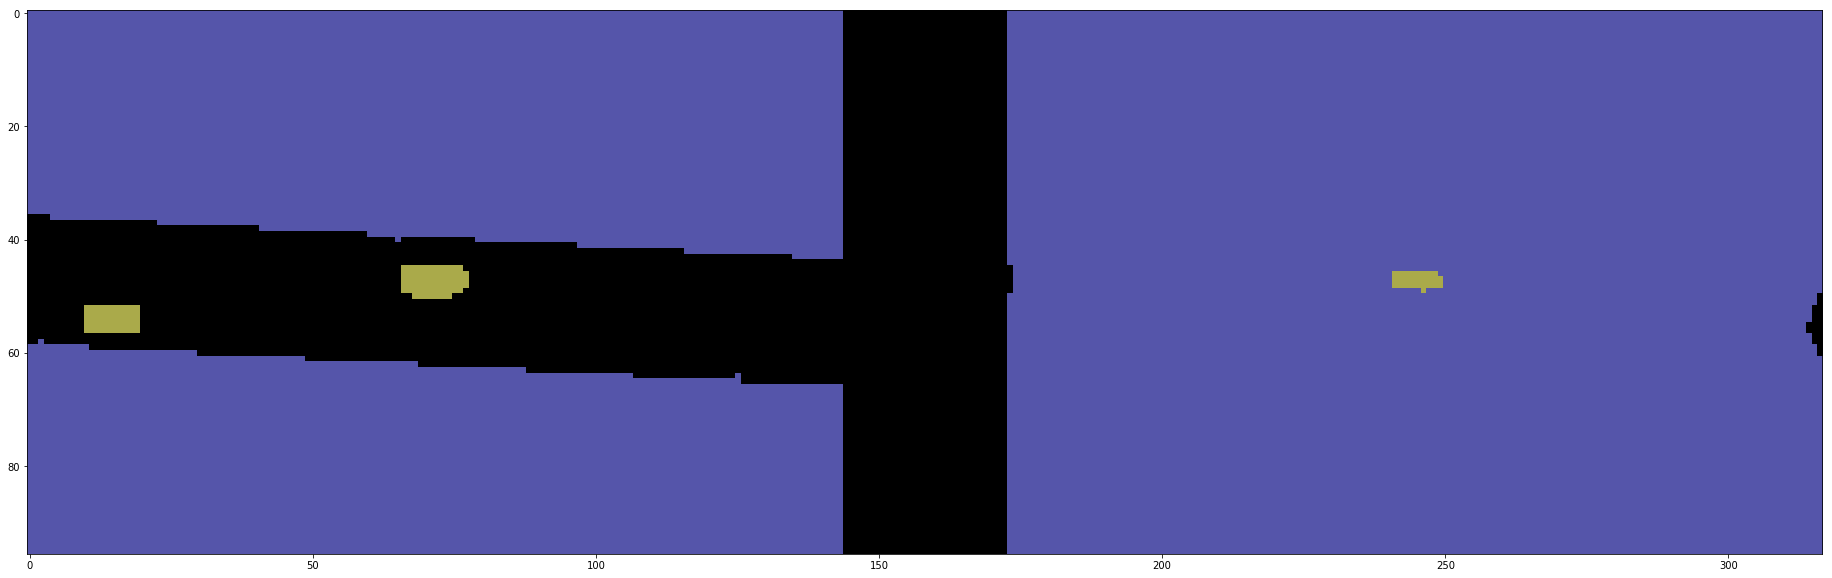

<Figure size 432x288 with 0 Axes>

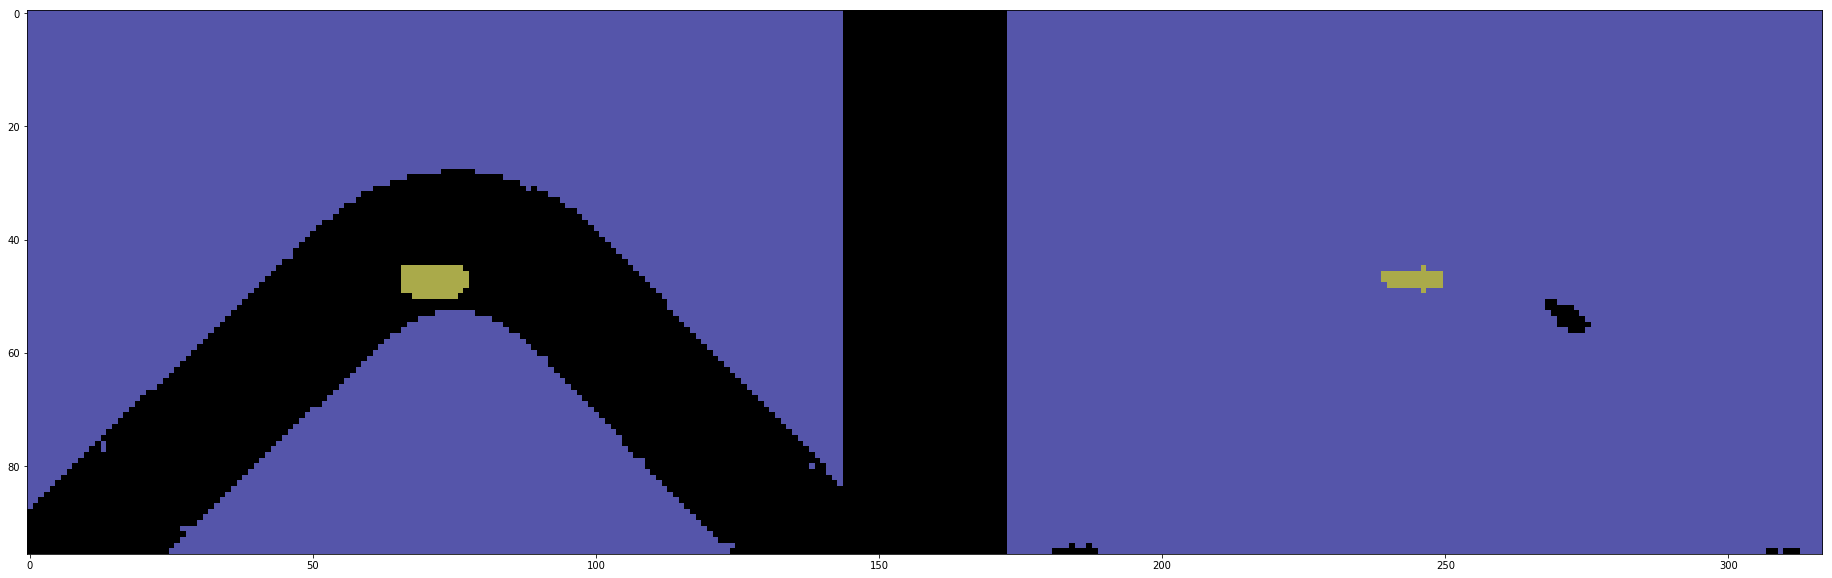

<Figure size 432x288 with 0 Axes>

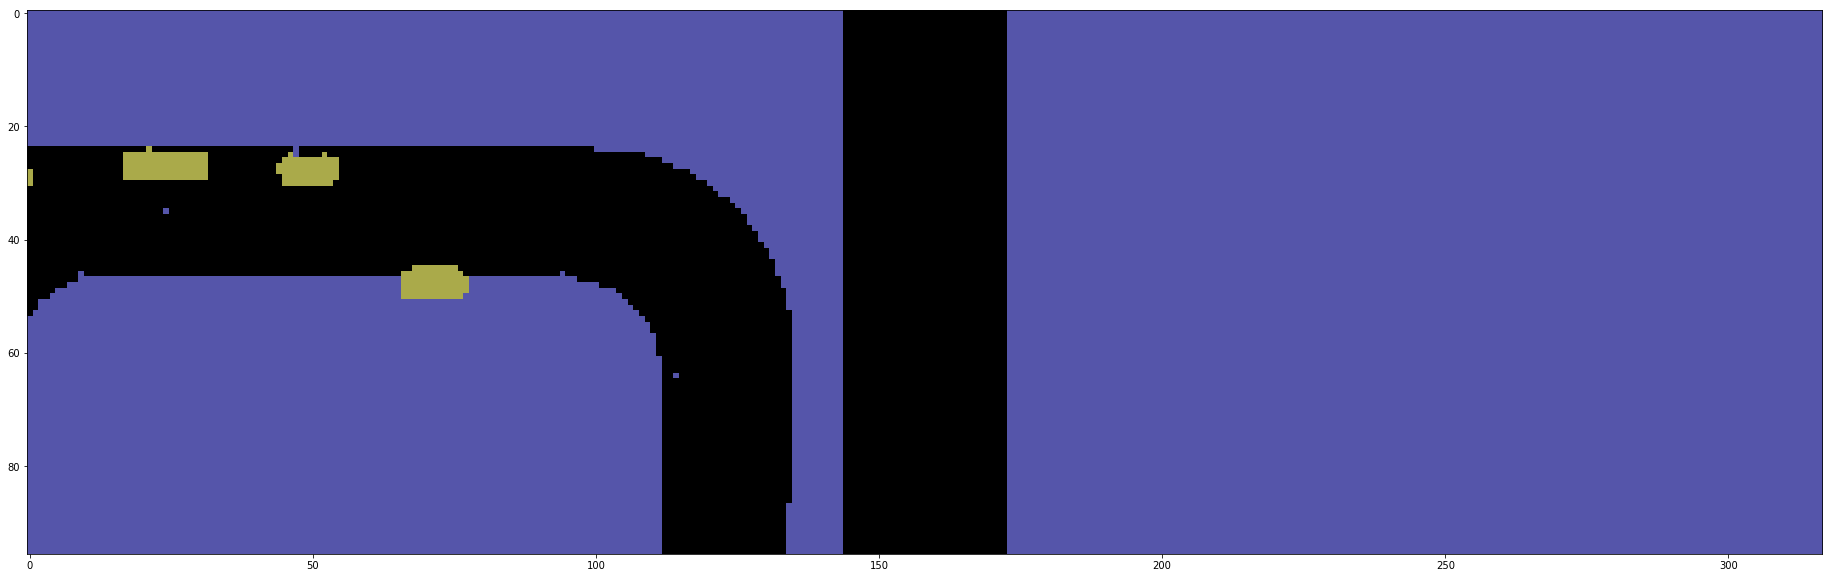

<Figure size 432x288 with 0 Axes>

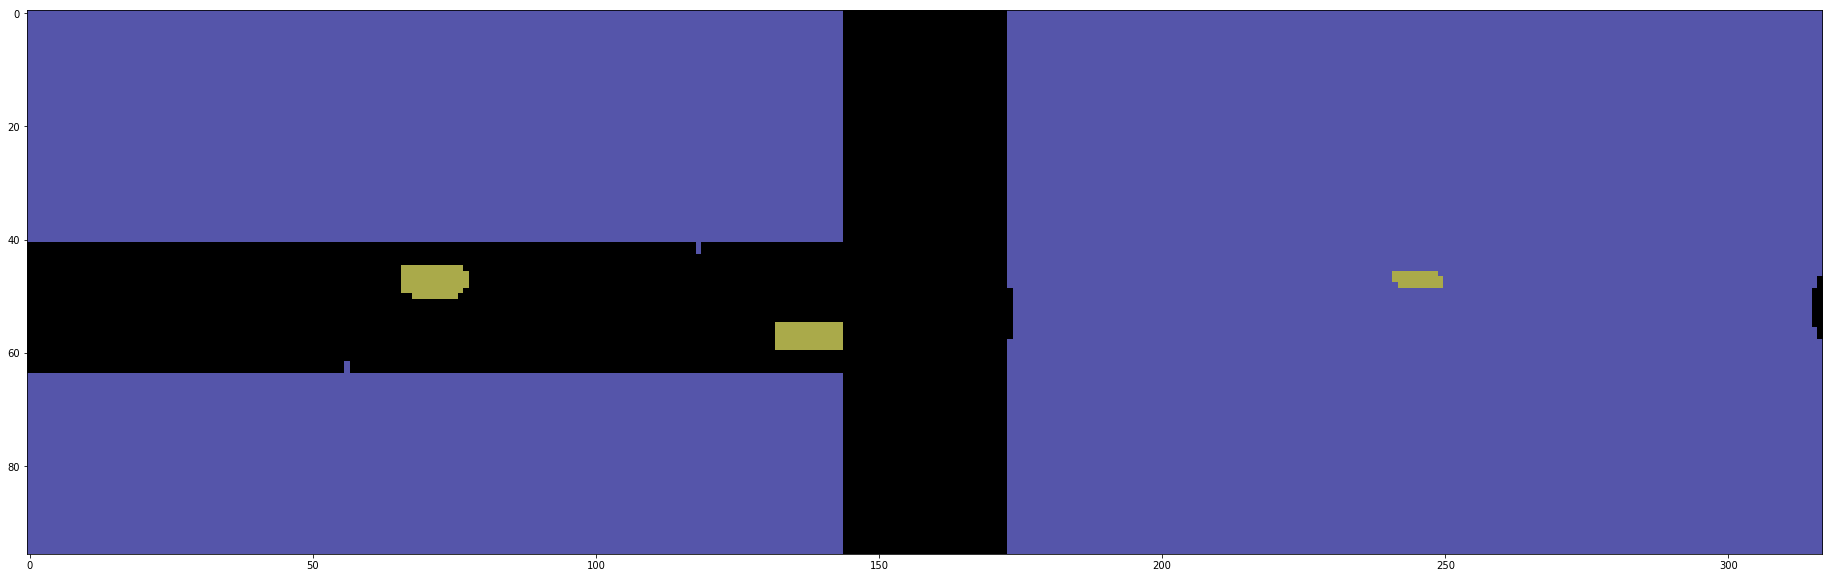

<Figure size 432x288 with 0 Axes>

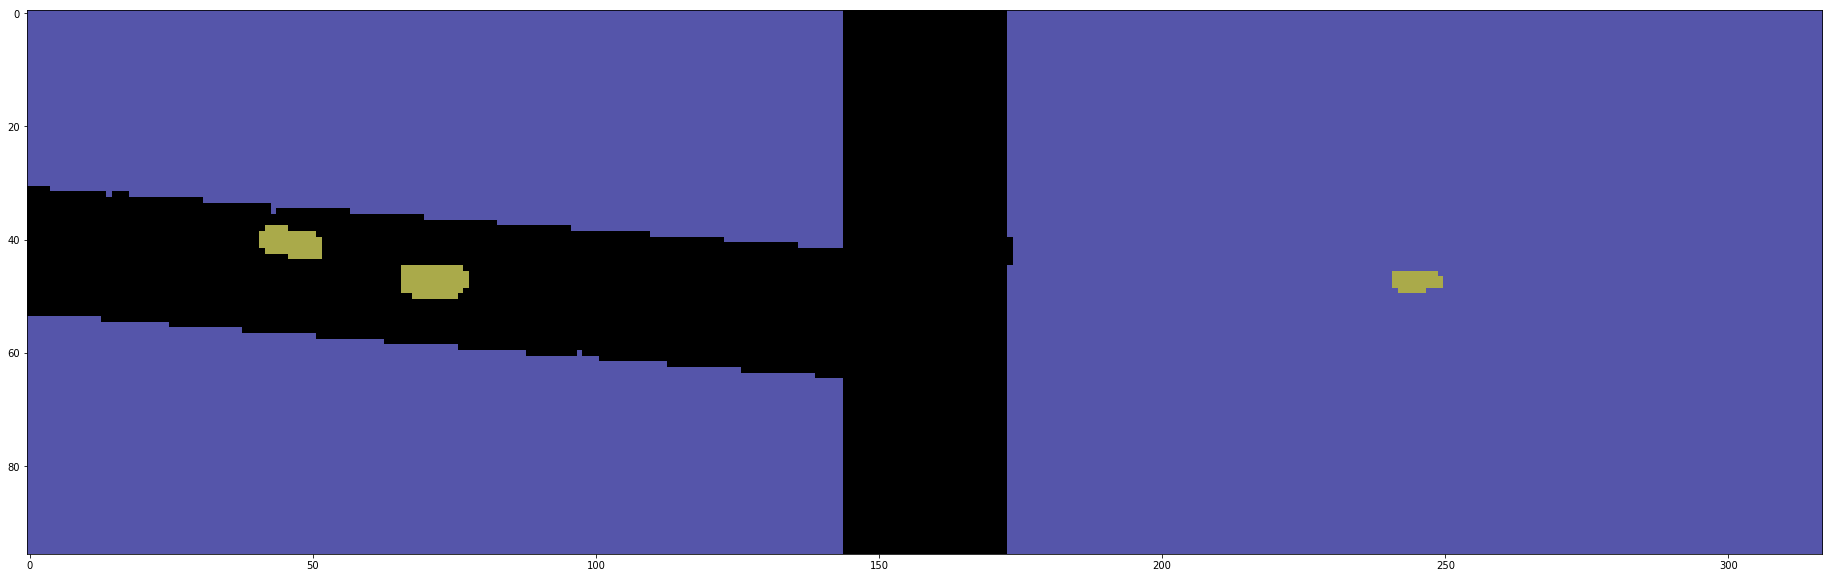

<Figure size 432x288 with 0 Axes>

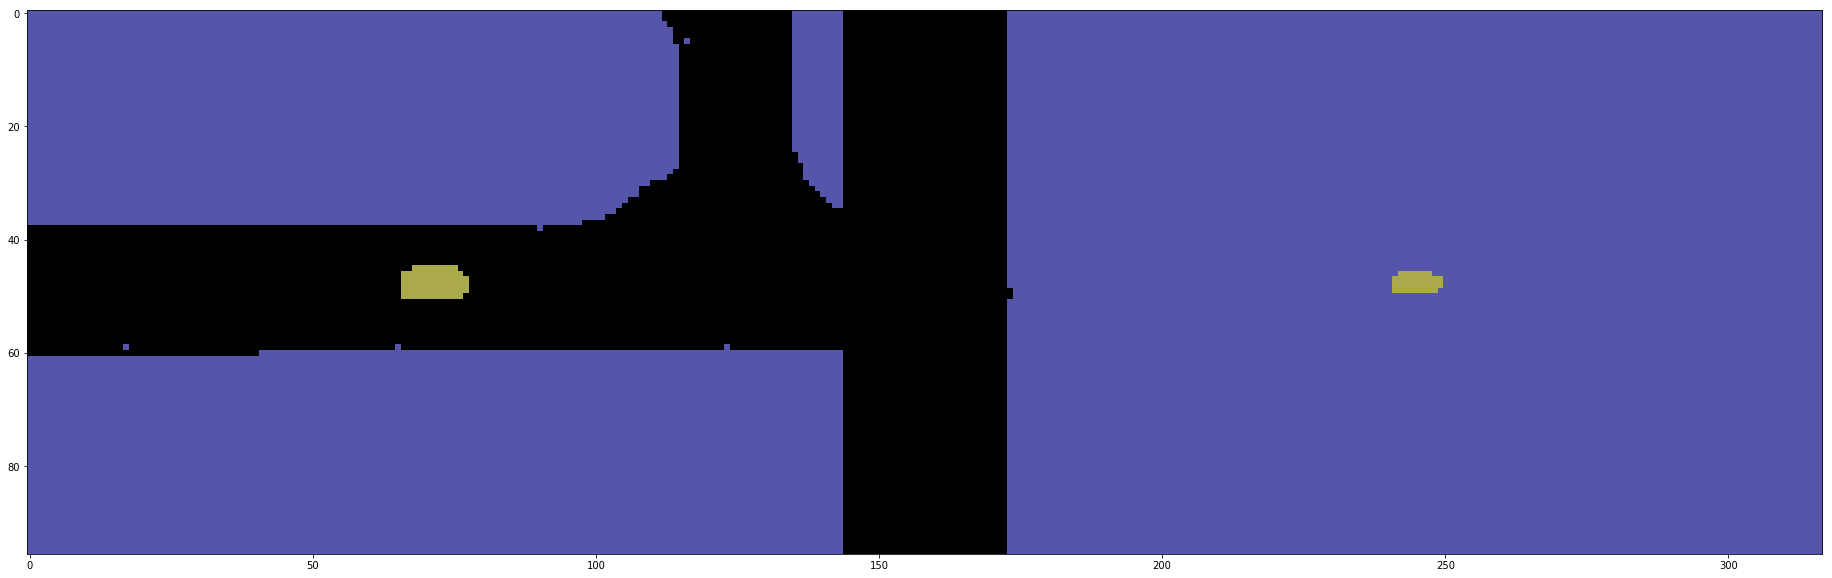

<Figure size 432x288 with 0 Axes>

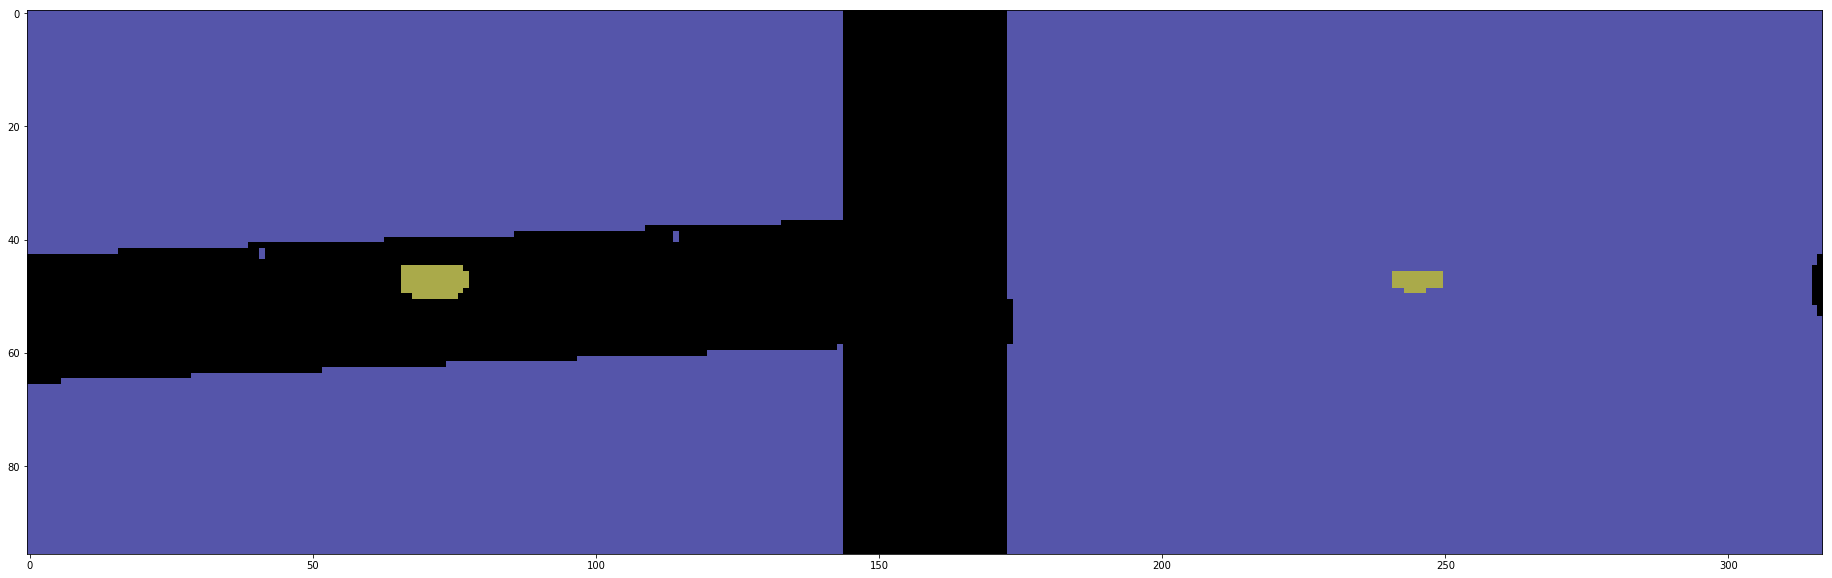


#### episodes = range(20, 27) #### (sweep: 0)
Epoch 1/50
175/175 [==============================] - 73s 420ms/step - loss: 0.6656 - val_loss: 0.1791
Epoch 2/50
175/175 [==============================] - 70s 400ms/step - loss: 0.1336 - val_loss: 0.0956
Epoch 3/50
175/175 [==============================] - 70s 399ms/step - loss: 0.0865 - val_loss: 0.0730
Epoch 4/50
175/175 [==============================] - 70s 400ms/step - loss: 0.0701 - val_loss: 0.0657
Epoch 5/50
175/175 [==============================] - 70s 400ms/step - loss: 0.0653 - val_loss: 0.0592
Epoch 6/50
175/175 [==============================] - 70s 401ms/step - loss: 0.0627 - val_loss: 0.0573
Epoch 7/50
175/175 [==============================] - 70s 400ms/step - loss: 0.0603 - val_loss: 0.0565
Epoch 8/50
  2/175 [..............................] - ETA: 44s - loss: 0.0475

In [ ]:
RECURRENT_EPISODES = [
    range(20, 27),
    range(27, 34),
    range(34, 40),
]


for sweep in range(12):
    histories = []
    for episodes in RECURRENT_EPISODES:
        start_time = time.time()
        storage = get_X_and_Y(['Town01', 'Town02'], episodes, DECIMATION, CAMERA_IDS, storage)
        X = [storage[id_] for id_ in CAMERA_IDS if 'Top' not in id_]
        Y = [storage[id_] for id_ in CAMERA_IDS if 'Top' in id_][0]
        print('Reading data took {:.2f} [s]'.format(time.time() - start_time))

        train_seq_gen = sequential_batcher(
            X, Y,
            return_sequences=False,
            batch_size=SEQ_BATCH_SIZE,
            sequence_len=SEQUENCE_LEN,
            classes_names=CLASSES_NAMES,
            val_part=0.0,
            validation=False,
        )
        
        one_batch_X, one_batch_Y = next(train_seq_gen)

        preds = recur_model.predict(one_batch_X)

        sep = np.zeros_like(preds[0:1, :, ::5])
        for j in range(len(preds)):
            plot_semantic(np.concatenate([one_batch_Y[j:j+1], sep, preds[j:j+1]], axis=2))
        
        print('\n#### episodes = {} #### (sweep: {})'.format(episodes, sweep))

        history = recur_model.fit_generator(
            train_seq_gen,
            steps_per_epoch=X[0].shape[-1] // SEQ_BATCH_SIZE // 10,
            epochs=50,
            validation_data=valid_seq_gen,
            validation_steps=X_val[0].shape[-1] // SEQ_BATCH_SIZE // 2,
            callbacks=[early_stopping],
        )
        
        histories.append(history.history)

        del X
        del Y
        
    val_loss = history.history['val_loss'][-(patience+1)]
    model_filename = 'models/recur_model__sweep={}_decimation={}_numclasses={}_valloss={:.3f}.h5'.format(sweep, DECIMATION, len(CLASSES_NAMES), val_loss)
    multi_model.save(model_filename)
    histories_filename = 'histories/recur_model__sweep={}_decimation={}_numclasses={}_valloss={:.3f}.pkl'.format(sweep, DECIMATION, len(CLASSES_NAMES), val_loss)
    with open(histories_filename, 'wb') as output:
        pickle.dump(histories, output)